In [1]:
import time
start = time.time()

In [2]:
from google.colab import drive

In [3]:
import io
import pandas as pd
import re
from datetime import timedelta
import numpy as np
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as preprocessing
import seaborn as sn
import matplotlib.pyplot as plt

In [4]:
!wget -O training.csv https://surfdrive.surf.nl/files/index.php/s/aNVxBfvZl273kKN/download   
!wget -O test.csv https://surfdrive.surf.nl/files/index.php/s/0lJ3j0RlMeychGj/download   


path_test = '/content/test.csv'
path_train = '/content/training.csv'

--2022-03-10 09:35:40--  https://surfdrive.surf.nl/files/index.php/s/aNVxBfvZl273kKN/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26049572 (25M) [text/csv]
Saving to: ‘training.csv’

training.csv        100%[===================>]  24.84M  18.7MB/s    in 1.3s    

2022-03-10 09:35:42 (18.7 MB/s) - ‘training.csv’ saved [26049572/26049572]

--2022-03-10 09:35:42--  https://surfdrive.surf.nl/files/index.php/s/0lJ3j0RlMeychGj/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5819692 (5.5M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]   5.55M  7.45MB/s    in 0.

In [5]:
# # This is for when you read the data in jupyther notebooks
# path_test = '/content/BPI_Challenge_2012-test.csv'
# path_train = '/content/BPI_Challenge_2012-training.csv'

In [6]:
df_train = pd.read_csv (path_train)
df_test = pd.read_csv (path_test)

In [7]:
# Keeping in test set only cases that started in test and not in train

train_cases = list(set(list(df_train['case concept:name'])))
test_cases = list(set(list(df_test['case concept:name'])))
test_keep = [item for item in test_cases if item not in train_cases]

df_test = df_test[df_test['case concept:name'].isin(test_keep)]

df_show = df_test.copy()

In [8]:
df_train['event time:timestamp']= pd.to_datetime(df_train['event time:timestamp'])

df_train = df_train.sort_values(by=['case concept:name', 'event time:timestamp'])

df_train = df_train.assign(actualaction=(df_train.groupby('case concept:name')['event concept:name'].shift(-1)))

df_train = df_train.assign(nexttime=(df_train.groupby('case concept:name')['event time:timestamp'].shift(-1)))
df_train['tonext'] = (df_train.nexttime - df_train['event time:timestamp']).astype('timedelta64[s]')

In [9]:
df_test['event time:timestamp']= pd.to_datetime(df_test['event time:timestamp'])

df_test = df_test.sort_values(by=['case concept:name', 'event time:timestamp'])

df_test = df_test.assign(actualaction=(df_test.groupby('case concept:name')['event concept:name'].shift(-1)))

df_test = df_test.assign(nexttime=(df_test.groupby('case concept:name')['event time:timestamp'].shift(-1)))
df_test['tonext'] = (df_test.nexttime - df_test['event time:timestamp']).astype('timedelta64[s]')

In [10]:
xtrain = df_train['event concept:name']
xtrain = xtrain.to_numpy()
xtest = df_test['event concept:name']
xtest = xtest.to_numpy()
x = np.concatenate((xtrain, xtest))

In [11]:
ytrain = df_train['actualaction']
ytrain = ytrain.to_numpy()
ytest = df_test['actualaction']
ytest = ytest.to_numpy()
y = np.concatenate((ytrain, ytest))

In [12]:
onehot = np.concatenate((x, y))

In [13]:
targets = onehot
labelEnc = preprocessing.LabelEncoder()
new_target = labelEnc.fit_transform(targets)
onehotEnc = preprocessing.OneHotEncoder()
onehotEnc.fit(new_target.reshape(-1, 1))
targets_trans = onehotEnc.transform(new_target.reshape(-1, 1))

In [14]:
x_train = targets_trans.toarray()[:214377]
x_test = targets_trans.toarray()[214377:262200]
ya_train = targets_trans.toarray()[262200:-47823]
ya_test = targets_trans.toarray()[-47823:]
yt_train = df_train.tonext.fillna(0).to_numpy()
yt_test = df_test.tonext.fillna(0).to_numpy()

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(yt_train.reshape(-1, 1))

MinMaxScaler()

In [16]:
yt_test = scaler.transform(yt_test.reshape(-1, 1))
yt_train = scaler.transform(yt_train.reshape(-1, 1))

In [17]:
model_activity = Sequential()
model_activity.add(LSTM(32, input_shape=(25,1)))
model_activity.add(Dense(25))

In [18]:
model_activity.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])

In [19]:
model_activity.fit(x_train, ya_train, epochs=10, batch_size=56)

Epoch 1/10
3829/3829 [==============================] - 97s 25ms/step - loss: 0.0258 - acc: 0.5180
Epoch 2/10
3829/3829 [==============================] - 92s 24ms/step - loss: 0.0211 - acc: 0.6115
Epoch 3/10
3829/3829 [==============================] - 94s 25ms/step - loss: 0.0206 - acc: 0.6186
Epoch 4/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0206 - acc: 0.6185
Epoch 5/10
3829/3829 [==============================] - 94s 25ms/step - loss: 0.0206 - acc: 0.6181
Epoch 6/10
3829/3829 [==============================] - 94s 24ms/step - loss: 0.0205 - acc: 0.6185
Epoch 7/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0205 - acc: 0.6193
Epoch 8/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0205 - acc: 0.6181
Epoch 9/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0205 - acc: 0.6195
Epoch 10/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0205 - acc: 0.6198


In [20]:
model_time = Sequential()
model_time.add(LSTM(32, input_shape=(25,1)))
model_time.add(Dense(1))

In [21]:
model_time.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])

In [22]:
model_time.fit(x_train, yt_train, epochs=10, batch_size=56)

Epoch 1/10
3829/3829 [==============================] - 95s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 2/10
3829/3829 [==============================] - 94s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 3/10
3829/3829 [==============================] - 92s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 4/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 5/10
3829/3829 [==============================] - 92s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 6/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 7/10
3829/3829 [==============================] - 92s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 8/10
3829/3829 [==============================] - 94s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 9/10
3829/3829 [==============================] - 92s 24ms/step - loss: 0.0041 - acc: 0.2582
Epoch 10/10
3829/3829 [==============================] - 93s 24ms/step - loss: 0.0041 - acc: 0.2582


In [23]:
predicted_activity = model_activity.predict(x_test)

In [24]:
predicted_time = model_time.predict(x_test)

In [25]:
max_index_row = np.argmax(predicted_activity, axis=1)
convpred = np.zeros(predicted_activity.shape)

In [26]:
for i in range (convpred.shape[0]):
  j = max_index_row[i]
  convpred[i][j] = 1

In [27]:
newarray = np.concatenate((x_train, convpred, ya_train, ya_test))
invers_conv = onehotEnc.inverse_transform(newarray)

In [28]:
activity_name_mapping = dict(zip(labelEnc.classes_, labelEnc.transform(labelEnc.classes_)))
inv_activity_name_mapping = {v: k for k, v in activity_name_mapping.items()}

In [29]:
actpred = invers_conv[214377:262200]
actreal = invers_conv[-47823:]

In [30]:
df_conf = pd.DataFrame(np.concatenate((actpred, actreal), axis = 1), columns=['pred', 'real'])

In [31]:
df_conf['Predicted Activity'] = df_conf.pred.replace(inv_activity_name_mapping)

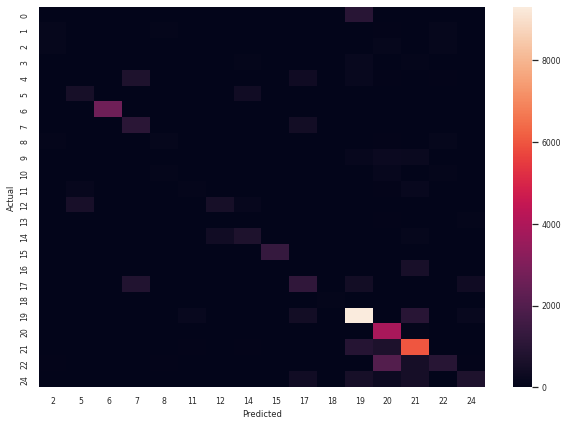

In [32]:
confusion_matrix = pd.crosstab(df_conf.real, df_conf.pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10,7))
sn.set(font_scale=.7) # for label size
sn.heatmap(confusion_matrix) # font size

plt.show()

In [33]:
accuracy_activity = 100 *len(df_test[df_conf.pred == df_conf.real]) / len(df_conf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [34]:
timepred = scaler.inverse_transform(predicted_time)
timereal = scaler.inverse_transform(yt_test)

In [35]:
temp = pd.DataFrame(np.concatenate((timepred, timereal), axis = 1), columns=['spred', 'sreal'])

In [36]:
temp['ts'] = df_test['event time:timestamp']
temp['ctsp'] = temp.ts + temp.spred.astype('timedelta64[s]')

In [37]:
temp['sdif'] = temp.sreal - temp.spred
temp['mdif'] = temp.sdif/60
temp['hdif'] = temp.mdif/60

In [38]:
msehours = (temp.hdif ** 2).mean()
meanhours = temp.hdif.mean() 
maehours = (abs(temp.hdif)).mean()
per30min = 100 * len(temp[abs(temp.mdif) - 30 < 0]) / len(temp)
per2d = 100 * len(temp[abs(temp.mdif) - 60*48 < 0]) / len(temp)
per1d = 100 * len(temp[abs(temp.mdif) - 60*24 < 0]) / len(temp)
per12h = 100 * len(temp[abs(temp.mdif) - 60*12 < 0]) / len(temp)
per6h = 100 * len(temp[abs(temp.mdif) - 60*6 < 0]) / len(temp)
per1h = 100 * len(temp[abs(temp.mdif) - 60 < 0]) / len(temp)
per5m = 100 * len(temp[abs(temp.mdif) - 5 < 0]) / len(temp)
per10m = 100 * len(temp[abs(temp.mdif) - 10 < 0]) / len(temp)
per20m = 100 * len(temp[abs(temp.mdif) - 20 < 0]) / len(temp)

In [39]:
print(f'MSE hours: {round(msehours,3)}')
print(f'MAE hours: {round(maehours,3)}')
print(f'mean hours: {round(meanhours,3)}')
print(f'percentage predicted within +- 2 days: {round(per2d, 2)}%')
print(f'percentage predicted within +- 1 day: {round(per1d, 2)}%')
print(f'percentage predicted within +- 12 hours: {round(per12h, 2)}%')
print(f'percentage predicted within +- 6 hours: {round(per6h, 2)}%')
print(f'percentage predicted within +- 1 hour: {round(per1h, 2)}%')
print(f'percentage predicted within +- 30 min: {round(per30min, 2)}%')
print(f'percentage predicted within +- 20 min: {round(per20m, 2)}%')
print(f'percentage predicted within +- 10 min: {round(per10m, 2)}%')
print(f'percentage predicted within +- 5 min: {round(per5m, 2)}%')

print(f'percentage actions predicted correctly: {round(accuracy_activity, 2)}%')

MSE hours: 266852.007
MAE hours: 161.005
mean hours: 10.288
percentage predicted within +- 2 days: 43.22%
percentage predicted within +- 1 day: 37.57%
percentage predicted within +- 12 hours: 35.45%
percentage predicted within +- 6 hours: 7.98%
percentage predicted within +- 1 hour: 3.12%
percentage predicted within +- 30 min: 3.1%
percentage predicted within +- 20 min: 3.1%
percentage predicted within +- 10 min: 0.29%
percentage predicted within +- 5 min: 0.28%
percentage actions predicted correctly: 61.33%


In [40]:
df_show['Predicted Activity'] = df_conf['Predicted Activity']
df_show['Predicted Time Stamp'] = temp['ctsp']

In [41]:
df_show

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,Predicted Activity,Predicted Time Stamp
0,44964012621824,206324,2012-02-03T17:17:11.047+01:00,2500,A_SUBMITTED,COMPLETE,03-02-2012 17:17:11.047,A_PARTLYSUBMITTED,2012-03-03 00:54:28.047
1,44964012621825,206324,2012-02-03T17:17:11.047+01:00,2500,A_PARTLYSUBMITTED,COMPLETE,03-02-2012 17:17:11.323,A_PREACCEPTED,2012-03-03 03:09:23.323
2,44964012621826,206324,2012-02-03T17:17:11.047+01:00,2500,A_DECLINED,COMPLETE,03-02-2012 17:17:42.964,NaN,2012-03-03 03:18:17.964
3,44968307589120,206327,2012-02-03T17:23:41.949+01:00,6000,A_SUBMITTED,COMPLETE,03-02-2012 17:23:41.949,A_PARTLYSUBMITTED,2012-03-03 01:00:58.949
4,44968307589121,206327,2012-02-03T17:23:41.949+01:00,6000,A_PARTLYSUBMITTED,COMPLETE,03-02-2012 17:23:42.504,A_PREACCEPTED,2012-03-03 03:15:54.504
...,...,...,...,...,...,...,...,...,...
47818,54666343743523,213276,2012-02-27T14:12:41.868+01:00,15000,W_Nabellen incomplete dossiers,START,14-03-2012 15:59:28.309,NaN,2012-03-15 02:00:03.309
47819,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,W_Nabellen incomplete dossiers,COMPLETE,14-03-2012 16:00:09.680,W_Afhandelen leads,2012-03-15 18:41:04.680
47820,49495203119136,209595,2012-02-15T10:10:36.503+01:00,13000,W_Nabellen offertes,START,14-03-2012 16:02:03.883,A_PARTLYSUBMITTED,2012-03-14 23:39:20.883
47821,52342766436386,211624,2012-02-21T23:38:40.044+01:00,35000,W_Nabellen incomplete dossiers,START,14-03-2012 16:04:46.192,A_PREACCEPTED,2012-03-15 01:56:58.192


In [42]:
end = time.time()
print(end-start)

1985.5656168460846
